In [1]:
import nltk
import pickle
import numpy as np
import re
import pandas as pd

from gensim import corpora
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary
import gensim.models
from sklearn.datasets import fetch_20newsgroups
from nltk.corpus import stopwords


from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib import pyplot as plt

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
class Tokenizer:
    def __init__(self):
        self._tokenizer = nltk.RegexpTokenizer(r'\w+')

    def tokenize(self, document: str) -> list:
        return self._tokenizer.tokenize(document)

In [ ]:
class Lemmatizer:
    def __init__(self):
        self._lemmatizer = WordNetLemmatizer()
        self._tokenizer = Tokenizer()
        self._stopwords = list(set(stopwords.words("english")))
        self._custom_stop_words = ['the', 'and', 'is', 'in', 'it', 'of', 'for', 'to', 'with', 'on']
        self._stopwords.extend(['two', 'one', 'way', 'pt', 'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


    def _tokenize(self, document: str) -> list:
        return self._tokenizer.tokenize(document)

    def _remove_special_characters_and_numbers(self, word) -> str:
        # Remove special characters and numbers using regular expressions
        cleaned_text = re.sub(r'[^A-Za-z\s]', '', word)  # Remove special characters
        cleaned_text = re.sub(r'\b\d+\b', '', cleaned_text)  # Remove standalone numbers
        return cleaned_text

    def lemmatize_word(self, word: str, pos=None) -> str:
        return self._lemmatizer.lemmatize(word, pos) if pos is not None else self._lemmatizer.lemmatize(word)

    def lemmatize_sentence(self, sentence: str, pos=None) -> str:
        result = []
        sentence = sentence.lower()
        for word in self._tokenize(sentence):
            word = self._remove_special_characters_and_numbers(word)
            if word.lower() in self._stopwords or word.lower() in self._custom_stop_words or len(word) < 3:
                continue
            if pos is not None:
                result.append(self.lemmatize_word(word, pos))
            else:
                result.append(self.lemmatize_word(word))
        return result

    def lemmatize_document(self, document: list) -> str:
        result = []
        for line in document:
            result.append(self.lemmatize_sentence(line))
        return result

In [2]:
## Load text data
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']

In [5]:
docs[:4]

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

In [ ]:
# Task 1: Initiate a new topic model
def fit_topic_model(docs):
  # Lemmatize document from your text data
  lemmatizer = Lemmatizer()
  docss = lemmatizer.lemmatize_document(docs)

  # Create a corpus from a list of texts
  common_dictionary = Dictionary(docss)
  common_corpus = [common_dictionary.doc2bow(text) for text in docss]

  # Train the model on the corpus.
  # corpus has to be provided as a keyword argument, as they are passed through to the children.
  elda = gensim.models.LdaModel(corpus=common_corpus,
                                id2word=common_dictionary,
                                num_topics=4,
                                random_state=100,
                                #update_every=1,
                                #chunksize=100,
                                passes=10,
                                #alpha='auto',
                                per_word_topics=False)
  return elda, common_corpus, docss

In [ ]:
# Task 2: Topics and its list of documents
# One dominant topic per document
# input: [common_corpus, docss, fitted_topic_model]
# output: [topic_id, list of doc ids]

def format_topics_document_unique(corpus, texts, ldamodel = None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([i, int(topic_num), round(prop_topic,4), topic_keywords]).to_frame().T])
            else:
                break
    sent_topics_df.reset_index(inplace = True, drop = True)
    sent_topics_df.columns = ['Doc_ID', 'Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)

    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1).groupby("Dominant_Topic")["Doc_ID"].apply(list).reset_index()
    # print(sent_topics_df)
    return(sent_topics_df)

In [ ]:
# Task 3: Topics and its list of documents
# Multiple topics per document if percentage contribution > 0.1
# input: [common_corpus, docss, fitted_topic_model]
# output: [topic_id, list of doc ids]

def format_topics_document_multiple(corpus, texts, ldamodel = None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if prop_topic > 0.1:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = pd.concat([sent_topics_df, pd.Series([i, int(topic_num), round(prop_topic,4), topic_keywords]).to_frame().T])
            else:
                break
    sent_topics_df.reset_index(inplace = True, drop = True)
    sent_topics_df.columns = ['Doc_ID', 'Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)

    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1).groupby("Dominant_Topic")["Doc_ID"].apply(list).reset_index()
    # print(sent_topics_df)
    return(sent_topics_df)

In [ ]:
a,b,c = fit_topic_model(docs)

In [ ]:
result = format_topics_document_unique(b, c, a)

In [ ]:
result

,Dominant_Topic,Doc_ID
0,0,"[1, 3, 4, 5, 14, 21, 22, 25, 27, 28, 32, 35, 3..."
1,1,"[9, 10, 11, 12, 13, 18, 29, 40, 56, 64, 66, 76..."
2,2,"[0, 2, 6, 7, 8, 16, 17, 19, 20, 23, 26, 30, 31..."
3,3,"[15, 24, 44, 60, 90, 115, 179, 188, 197, 229, ..."


In [ ]:
# Task 4. Plot Wordcloud of Top N words in each topic
def word_cloud_word_weight_per_topic(ldamodel, figurename = 'word_cloud_per_topic.png'):

  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

  cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

  topics = ldamodel.show_topics(4, formatted=False)

  fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

  for i, ax in enumerate(axes.flatten()):
      fig.add_subplot(ax)
      topic_words = dict(topics[i][1])
      cloud.generate_from_frequencies(topic_words, max_font_size=300)
      plt.gca().imshow(cloud)
      plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
      plt.gca().axis('off')


  plt.subplots_adjust(wspace=0, hspace=0)
  plt.axis('off')
  plt.margins(x=0, y=0)
  plt.tight_layout()
  plt.savefig('word_cloud_per_topic.png')

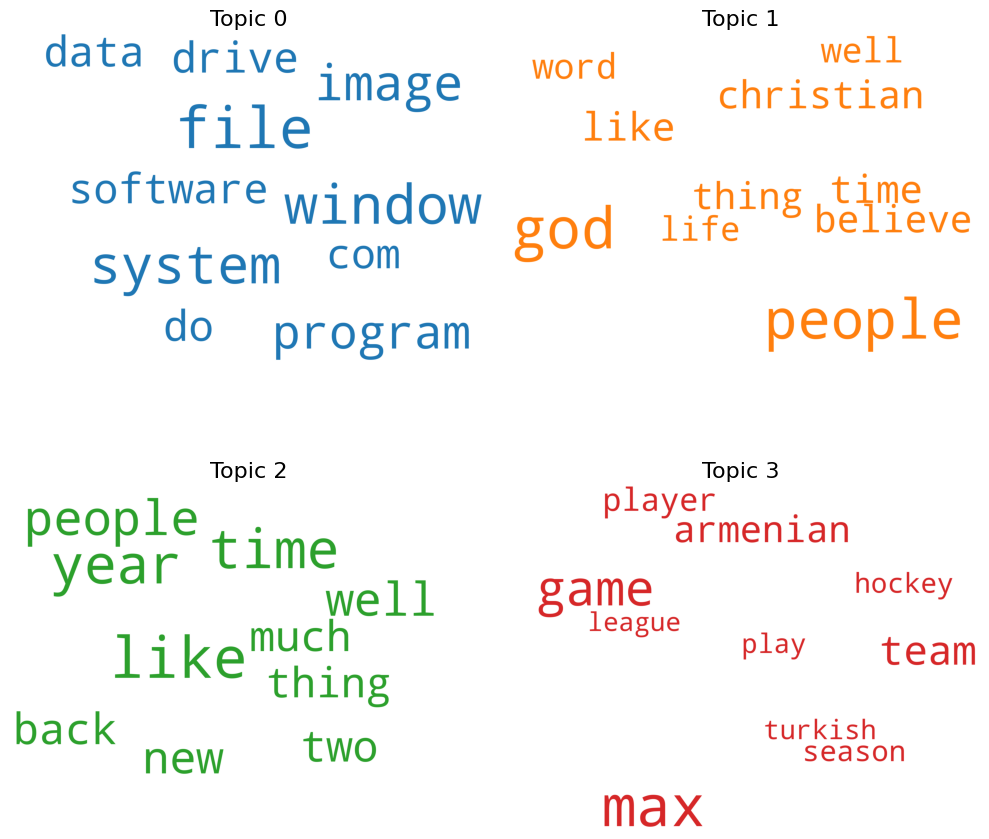

In [ ]:
word_cloud_word_weight_per_topic(a)

In [ ]:
topics = a.show_topics(num_words= 10, formatted = False)

In [ ]:
plot_pair = {}
for i, pairs in topics:
  current = [{'term': k[0], 'weight': k[1]} for k in pairs]
  print(current)

[{'term': 'file', 'weight': 0.007521887}, {'term': 'window', 'weight': 0.006815328}, {'term': 'system', 'weight': 0.0064766584}, {'term': 'image', 'weight': 0.0056076143}, {'term': 'program', 'weight': 0.005037965}, {'term': 'drive', 'weight': 0.0040480876}, {'term': 'do', 'weight': 0.00403594}, {'term': 'data', 'weight': 0.003979938}, {'term': 'software', 'weight': 0.0038830366}, {'term': 'com', 'weight': 0.0038026944}]
[{'term': 'god', 'weight': 0.0085395}, {'term': 'people', 'weight': 0.007941546}, {'term': 'like', 'weight': 0.003342711}, {'term': 'time', 'weight': 0.0033003988}, {'term': 'christian', 'weight': 0.0031944644}, {'term': 'believe', 'weight': 0.003082522}, {'term': 'thing', 'weight': 0.0029895653}, {'term': 'word', 'weight': 0.0026895287}, {'term': 'well', 'weight': 0.0026139955}, {'term': 'life', 'weight': 0.002476409}]
[{'term': 'like', 'weight': 0.005704959}, {'term': 'year', 'weight': 0.0051820856}, {'term': 'time', 'weight': 0.0051298207}, {'term': 'people', 'weigh

In [ ]:
[{'topic_id': i, 'word_weight' :[{'term': k[0], 'weight': k[1]} for k in pairs]} for i, pairs in topics]

[{'topic_id': 0,
  'word_weight': [{'term': 'file', 'weight': 0.007521887},
   {'term': 'window', 'weight': 0.006815328},
   {'term': 'system', 'weight': 0.0064766584},
   {'term': 'image', 'weight': 0.0056076143},
   {'term': 'program', 'weight': 0.005037965},
   {'term': 'drive', 'weight': 0.0040480876},
   {'term': 'do', 'weight': 0.00403594},
   {'term': 'data', 'weight': 0.003979938},
   {'term': 'software', 'weight': 0.0038830366},
   {'term': 'com', 'weight': 0.0038026944}]},
 {'topic_id': 1,
  'word_weight': [{'term': 'god', 'weight': 0.0085395},
   {'term': 'people', 'weight': 0.007941546},
   {'term': 'like', 'weight': 0.003342711},
   {'term': 'time', 'weight': 0.0033003988},
   {'term': 'christian', 'weight': 0.0031944644},
   {'term': 'believe', 'weight': 0.003082522},
   {'term': 'thing', 'weight': 0.0029895653},
   {'term': 'word', 'weight': 0.0026895287},
   {'term': 'well', 'weight': 0.0026139955},
   {'term': 'life', 'weight': 0.002476409}]},
 {'topic_id': 2,
  'word_

In [ ]:
# Task 5: Word Count of Top N words in each topic among topic related documents
def get_topic_word_weight_related_document(ldamodel, texts, doc_list_per_topic):
  topics = ldamodel.show_topics(formatted=False)
  out = []
  topic_set = set([])
  for i, topic in topics:
    data_flat = [w for j, w_list in enumerate(texts) if j in doc_list_per_topic.iloc[i, 1] for w in w_list]
    counter = Counter(data_flat)
    for word, weight in topic:
      out.append([word, i, weight, counter[word]])
      topic_set.add(i)

  df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
  return df, topic_set

In [ ]:
df, topic_set = get_topic_word_weight_related_document(a, c, result)

In [ ]:
df

,word,topic_id,importance,word_count
0,file,0,0.007522,3520
1,window,0,0.006815,3177
2,system,0,0.006477,2667
3,image,0,0.005608,2053
4,program,0,0.005038,2211
5,drive,0,0.004048,1857
6,do,0,0.004036,1675
7,data,0,0.003980,1451
8,software,0,0.003883,1615
9,com,0,0.003803,1659


In [ ]:
# Task 6: Word Count of Top N words in each topic
def get_topic_word_weight(ldamodel, texts, doc_list_per_topic):
  topics = ldamodel.show_topics(formatted=False)
  data_flat = [w for w_list in texts for w in w_list]
  counter = Counter(data_flat)

  out = []
  topic_set = set([])
  for i, topic in topics:
      for word, weight in topic:
          out.append([word, i, weight, counter[word]])
          topic_set.add(i)

  df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
  return df, topic_set

In [ ]:
# Task 7: Barplot Word Count and Weights of Topic Keywords
# input: output of get_topic_word_weight, get_topic_word_weight_related_document
def plot_topic_word_wordcount_weight(df, topic_set):
  fig, axes = plt.subplots(2, 2, figsize=(10,6), sharey=True, dpi=160)
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
  for i, ax in enumerate(axes.flatten()):
      ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==list(topic_set)[i], :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
      ax_twin = ax.twinx()
      ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==list(topic_set)[i], :], color=cols[i], width=0.2, label='Weights')
      ax.set_ylabel('Word Count', color=cols[i])
      left_ylim = df['importance'].max() + 0.02
      right_ylim = df['word_count'].max() + 100
      ax_twin.set_ylim(0, left_ylim); ax.set_ylim(0, right_ylim)
      ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
      ax.tick_params(axis='y', left=True)
      ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
      ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

  fig.tight_layout(w_pad=2)
  fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
  plt.show()

<ipython-input-64-808c87ae9be8>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


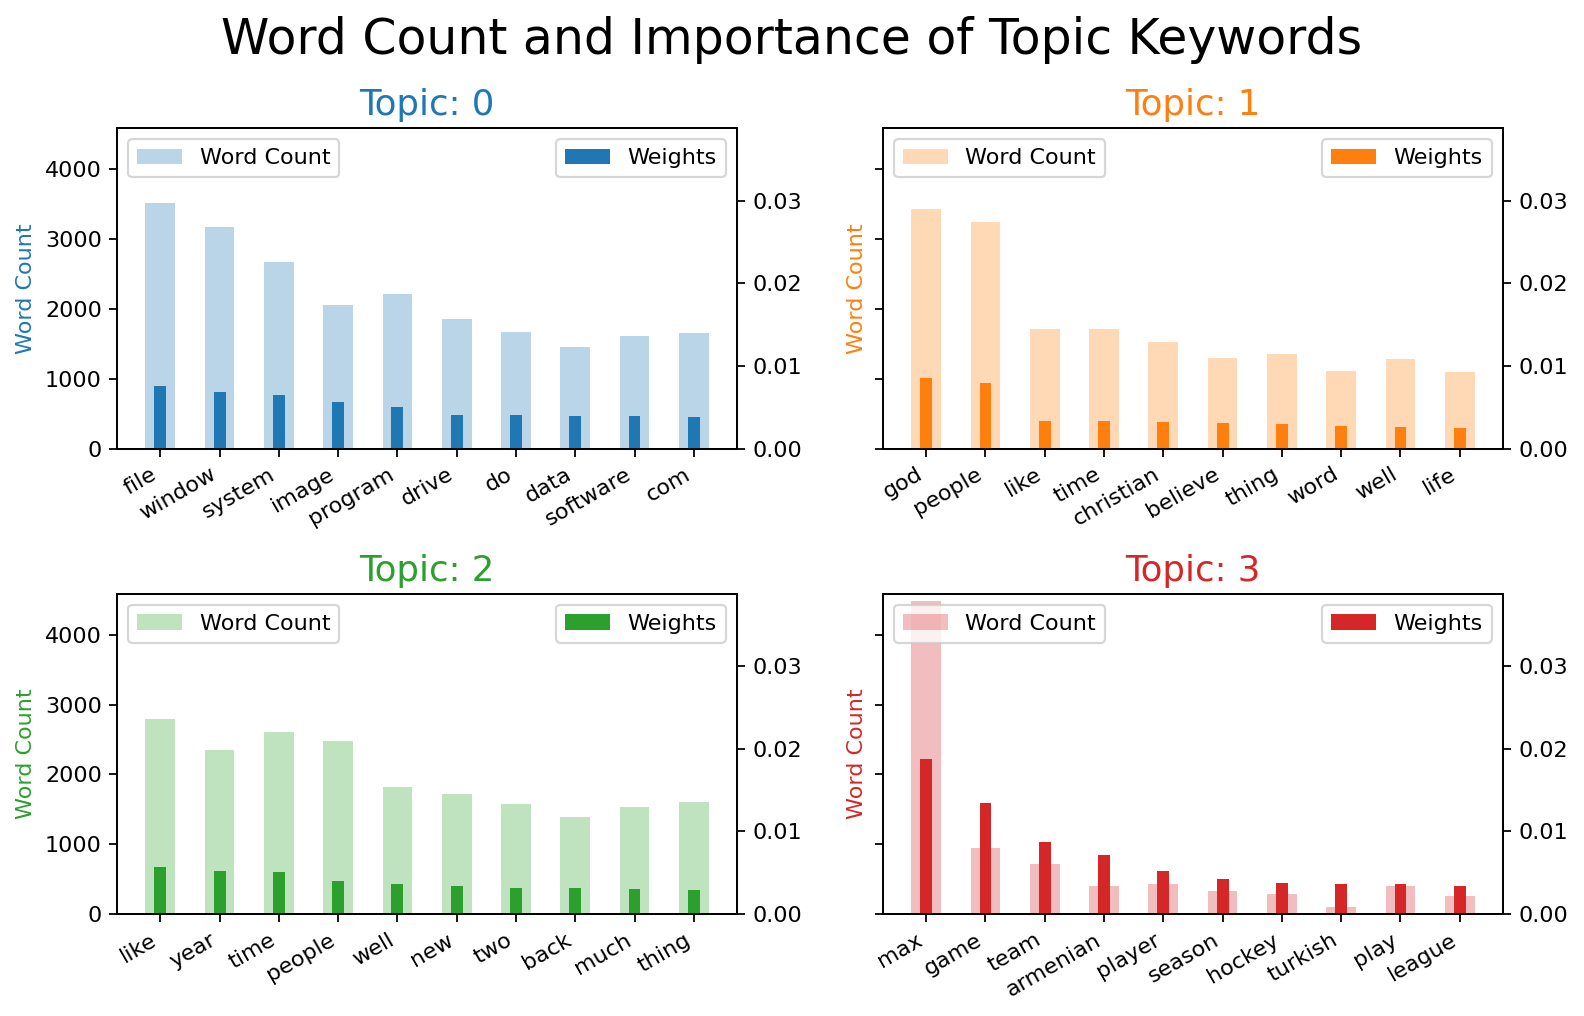

In [ ]:
plot_topic_word_wordcount_weight(df, topic_set)